In [ ]:
using_kaggle = True

In [ ]:
if using_kaggle:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install -q opencv-python matplotlib
    !{sys.executable} -m pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
#     !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_4b8939.pth

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
image_path = './images/dog.jpg'

In [ ]:
model_path = '../input/segment-anything/pytorch/vit-b/1/model.pth'

## Set-up

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [ ]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = model_path
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [ ]:
# masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
# print(len(masks))
# print(masks[0].keys())

Show all the masks overlayed on the image.

In [ ]:
# plt.figure(figsize=(5,5))
# plt.imshow(image)
# show_anns(masks)
# plt.axis('off')
# plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

In [ ]:
# plt.figure(figsize=(5,5))
# plt.imshow(image)
# show_anns(masks2)
# plt.axis('off')
# plt.show() 

In [ ]:
mask = np.where(masks2[23]['segmentation'], 1, 0)
new_image = image * np.expand_dims(mask, axis=-1)
# new_image.shape
plt.figure(figsize=(5,5))
plt.imshow(new_image)
plt.axis('off')
plt.show()

In [ ]:
# show each mask separately
# for i in range(len(masks2)):
#     print(i)
#     mask = np.where(masks2[i]['segmentation'], 1, 0)
#     new_image = image * np.expand_dims(mask, axis=-1)
#     plt.figure(figsize=(5,5))
#     plt.imshow(new_image)
#     plt.axis('off')
#     plt.show()

In [ ]:
# def is_part_of(mask1, mask2):
#     mask1, mask2 = mask1.flatten(), mask2.flatten()
#     # Check if mask1 is entirely contained within mask2
#     for m1, m2 in zip(mask1, mask2):
#         if m1 == 1 and m2 == 0:
#             return False
#     if np.count_nonzero(mask1)==np.count_nonzero(mask2):
#             return False
#     print(True, i)

In [ ]:
# to check objects belonging to mask23
# for i in range(len(masks2)):
#     is_part_of(masks2[i]['segmentation'], masks2[23]['segmentation'])

In [ ]:
# to check if mask21 belongs to another mask
# for i in range(len(masks2)):
#     is_part_of(masks2[21]['segmentation'], masks2[i]['segmentation'])

In [ ]:
# !pip install timm
import timm

In [ ]:
timm.list_models('convnext*tin*', pretrained=True)

In [ ]:
cv_model = timm.create_model('convnext_tiny.fb_in1k', pretrained=True).eval()
transform = timm.data.create_transform(
    **timm.data.resolve_data_config(cv_model.pretrained_cfg)
)

transform

In [ ]:
from PIL import Image
pil_image = Image.fromarray(new_image.astype(np.uint8))
image_tensor = transform(pil_image)

In [ ]:
output = cv_model(image_tensor.unsqueeze(0))
output.shape

In [ ]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
probabilities.shape

In [ ]:
values, indices = torch.topk(probabilities, 3)
indices

In [ ]:
import requests
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')
[{'label': IMAGENET_1k_LABELS[idx], 'value': np.round(val.item()*100, 2)} for val, idx in zip(values, indices)]

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(image_tensor, (1,2,0)))
# show_anns(masks2)
# plt.axis('off')
plt.show() 

----------------------

PyTorch version: 2.0.0
Torchvision version: 0.15.1
CUDA is available: True
--2023-07-17 12:21:42--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg’

dog.jpg             100%[===================>]  97.51K  --.-KB/s    in 0.01s   

2023-07-17 12:21:42 (6.51 MB/s) - ‘images/dog.jpg’ saved [99846/99846]



mask23 [{'label': 'French_bulldog', 'value in %': 29.01}, {'label': 'American_Staffordshire_terrier, Staffordshire_terrier, American_pit_bull_terrier, pit_bull_terrier', 'value in %': 21.14}]


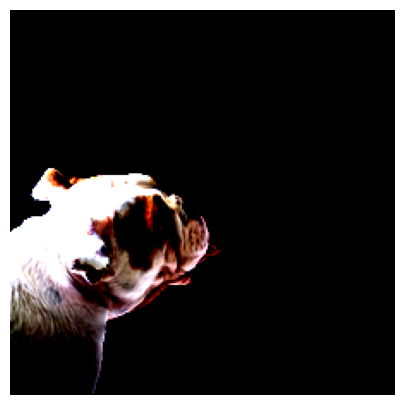

mask24 [{'label': 'black_swan, Cygnus_atratus', 'value in %': 53.89}]


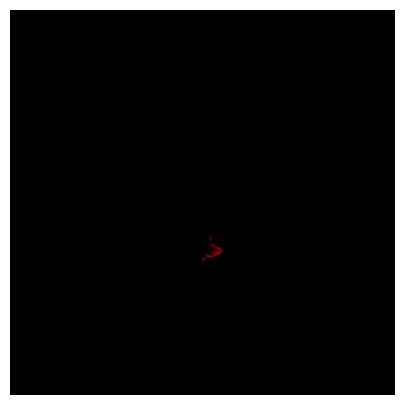

mask25 [{'label': 'water_ouzel, dipper', 'value in %': 46.94}]


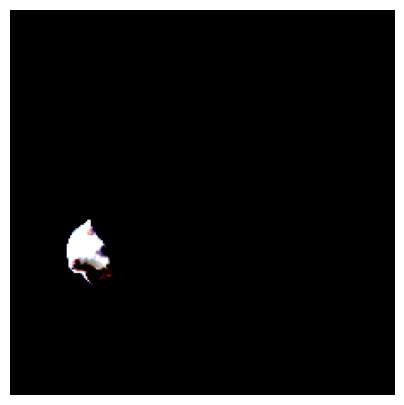

mask34 [{'label': 'horizontal_bar, high_bar', 'value in %': 44.28}]


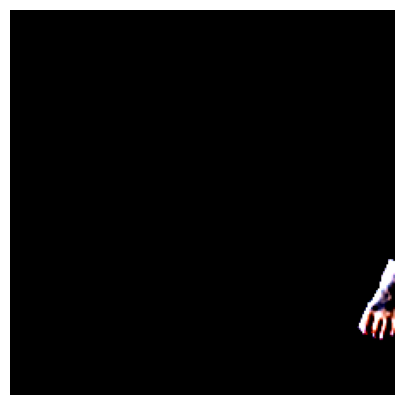

mask51 [{'label': 'mixing_bowl', 'value in %': 60.66}]


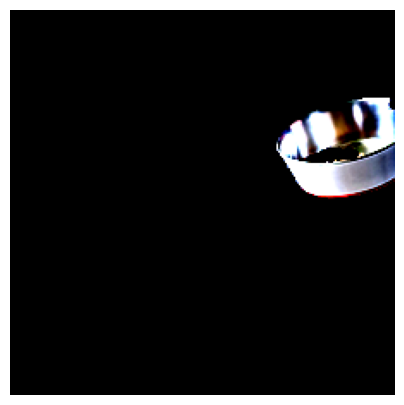

mask55 [{'label': 'balance_beam, beam', 'value in %': 26.17}]


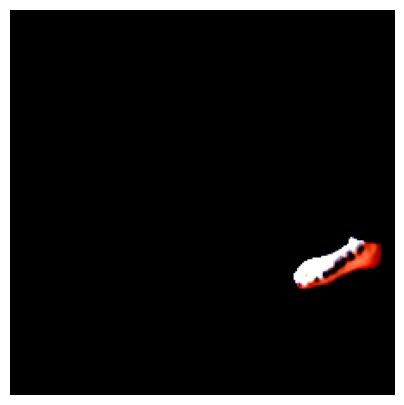

mask58 [{'label': 'jean, blue_jean, denim', 'value in %': 18.29}, {'label': 'balance_beam, beam', 'value in %': 15.06}]


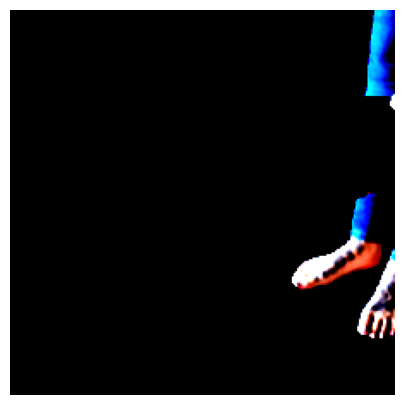

In [1]:
#algorithm for detecting and describing objects found in a given picture

#initial setup, imports

    # remember to change model install and to automate image_path and model path!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!        
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install -q opencv-python matplotlib
!{sys.executable} -m pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import timm
from PIL import Image

#image and model already in image_path, model_path
image_path = './images/dog.jpg'
model_path = '../input/segment-anything/pytorch/vit-b/1/model.pth'

#preparing image for cv2 (mask post-processing)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#preparing SAM automatic mask generator
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = model_path
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

#preparing masks2
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)
masks2 = mask_generator_2.generate(image)

#prepare cv_model and transform for inference
cv_model = timm.create_model('convnext_tiny.fb_in1k', pretrained=True).eval()
transform = timm.data.create_transform(
    **timm.data.resolve_data_config(cv_model.pretrained_cfg)
)

#ImageNet lookup table ready
import requests
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')

for i in range(len(masks2)):
    #convert mask to image
    mask = np.where(masks2[i]['segmentation'], 1, 0)
    new_image = image * np.expand_dims(mask, axis=-1)
    #convert image to pil to prep for transform
    pil_image = Image.fromarray(new_image.astype(np.uint8))
    #apply transform to prep for inference
    image_tensor = transform(pil_image)
    #inference
    output = cv_model(image_tensor.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    values, indices = torch.topk(probabilities, 1)
    lst = [{'label': IMAGENET_1k_LABELS[idx], 'value in %': np.round(val.item()*100, 2)} for val, idx in zip(values, indices) if val>0.15]
    if len(lst):
        # print predicted classes w/ probs
        print(f'mask{i}', lst)
        # show masks meeting criteria
        plt.figure(figsize=(5,5))
        plt.imshow(np.transpose(image_tensor, (1,2,0)))
        plt.axis('off')
        plt.show()

In [ ]:
# backlog
    # index, hyperlinks
    # -object is part of another object...    
    # -change sam model
    # -change cv model
    # -precision/recall curve to compare output quality